**Vector databases** are purpose-built to handle the unique structure of **vector embeddings**. They **index vectors** for **easy search and retrieval** by comparing values and finding those that are most similar to one another.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/document_similarity_check/'

/content/drive/MyDrive/Colab Notebooks/document_similarity_check


In [5]:
!pip install sentence-transformers pinecone-client -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.4/179.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 118.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.3 MB/s eta 0:00:00


In [6]:
import requests
import os
import pandas as pd
from sklearn.model_selection import train_test_split

## Loading text data into dataframe

In [7]:
folder_path = './data/docs'
folders = os.listdir(folder_path)
folders

['invoice', 'passport', 'receipt']

In [8]:
rows = []
for c in folders:
  docs = os.listdir(f"{folder_path}/{c}")
  for d in docs:
    with open(f"{folder_path}/{c}/{d}", "r") as file:
      rows.append([file.read(), c])

In [10]:
df = pd.DataFrame(rows, columns=["doc_text", "doc_type"])

In [11]:
df

,doc_text,doc_type
0,BuzyBee Management Services (002255953-A)\nMob...,invoice
1,coway\n\nCoway (Malaysia) Sdn. Bhd. (735a20-1)...,invoice
2,WILHIN MOTOR (M) SDN. BHD. eisssH\n\nNO. 4 & 5...,invoice
3,Experience of True Efficiency\n\n \n\nBILL TO\...,invoice
4,Hawaii Company Name\n\n \n\nINVOICE\n\n \n\n \...,invoice
...,...,...
294,Dion Realties Sdn Bhd (Ca. No:20154-T)\n(6ST R...,receipt
295,"A?_cil@s{ ""\n\nJIMART@SP3\nOGN GROUP SDN BHD\n...",receipt
296,\n\n \n\nKESTAURANT JIAWE |\nJIAWE| HOUSE\n\n...,receipt
297,\n\n \n\nONE ONE THREE SEAFOOD RESTAURANT SDN...,receipt


In [12]:
df['doc_type'].value_counts()

invoice     101
receipt     100
passport     98
Name: doc_type, dtype: int64

## preprocessing the texts

In [13]:
#removing stopwords from the text

#download stopwords data
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')


#load the set of stopwords

stop_words = set(stopwords.words('english'))
prt = nltk.stem.PorterStemmer()
def remove_stopwords(text):
    words = word_tokenize(text)
    tokens_pun_lower = [i.lower() for i in words if i.isalnum()]
    tokens_stop = [i for i in tokens_pun_lower if i not in stop_words]

    terms = [prt.stem(i) for i in tokens_stop]

    return " ".join(terms)

#Adding the processed text to the dataframe
df['processed_text'] = df['doc_text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
df

,doc_text,doc_type,processed_text
0,BuzyBee Management Services (002255953-A)\nMob...,invoice,buzybe manag servic mobil email info websit da...
1,coway\n\nCoway (Malaysia) Sdn. Bhd. (735a20-1)...,invoice,coway coway malaysia sdn bhd ail931694 level 2...
2,WILHIN MOTOR (M) SDN. BHD. eisssH\n\nNO. 4 & 5...,invoice,wilhin motor sdn bhd eisssh 4 5 pekan bt 11 ja...
3,Experience of True Efficiency\n\n \n\nBILL TO\...,invoice,experi true effici bill invok solut sdn bhd ja...
4,Hawaii Company Name\n\n \n\nINVOICE\n\n \n\n \...,invoice,hawaii compani name invoic slogan line 1 offic...
...,...,...,...
294,Dion Realties Sdn Bhd (Ca. No:20154-T)\n(6ST R...,receipt,dion realti sdn bhd ca 6st registr ho 00065024...
295,"A?_cil@s{ ""\n\nJIMART@SP3\nOGN GROUP SDN BHD\n...",receipt,jimart sp3 ogn group sdn bhd roc jalan dinar g...
296,\n\n \n\nKESTAURANT JIAWE |\nJIAWE| HOUSE\n\n...,receipt,kestaur jiaw hous 13 jln tasik utama 8 medan n...
297,\n\n \n\nONE ONE THREE SEAFOOD RESTAURANT SDN...,receipt,one one three seafood restaur sdn bhd aman sri...


<Axes: >

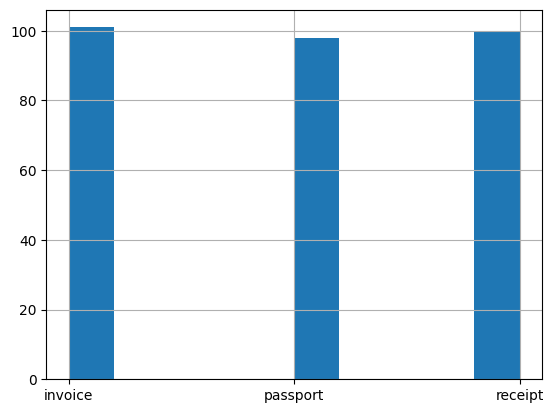

In [15]:
df.doc_type.hist()

In [17]:
df = df.drop(['doc_text'], axis=1)
df = df.rename(columns={'processed_text': 'doc_text'})
df

,doc_type,doc_text
0,invoice,buzybe manag servic mobil email info websit da...
1,invoice,coway coway malaysia sdn bhd ail931694 level 2...
2,invoice,wilhin motor sdn bhd eisssh 4 5 pekan bt 11 ja...
3,invoice,experi true effici bill invok solut sdn bhd ja...
4,invoice,hawaii compani name invoic slogan line 1 offic...
...,...,...
294,receipt,dion realti sdn bhd ca 6st registr ho 00065024...
295,receipt,jimart sp3 ogn group sdn bhd roc jalan dinar g...
296,receipt,kestaur jiaw hous 13 jln tasik utama 8 medan n...
297,receipt,one one three seafood restaur sdn bhd aman sri...


In [18]:
train_df, valid_df = train_test_split(df, random_state=42, train_size=0.8, stratify=df.doc_type.values)
train_df.shape, valid_df.shape

((239, 2), (60, 2))

In [40]:
# train_df
# valid_df

In [25]:
len(df), len(train_df), len(valid_df)

(299, 239, 60)

In [24]:
train_df[train_df['doc_type']=="invoice"].head()

,doc_type,doc_text
80,invoice,harbor technolog
95,invoice,invoic adob system softwar memo invoic ireland...
81,invoice,g b 8 tnedto oo gnebi mevai ey sempaen g5 b 12...
18,invoice,stee bear ltd bill steel bear product 2200 kat...
48,invoice,compani name applesourc softwar 1999 woodsid m...


In [26]:
import pinecone
pinecone.init(api_key='API-KEY', environment='gcp-starter')# environment='us-west1-gcp'

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2',device='cuda')

In [28]:
embeding = model.encode("This is sentence")
len(embeding)

768

In [31]:
pinecone.create_index(name='doc-search', dimension=768)

In [32]:
index = pinecone.Index('doc-search')

In [33]:
# [(id,vector,metadata),]
question_list = []
for i,row in train_df.iterrows():
  question_list.append(
      (
        str(i),
        model.encode(row['doc_text']).tolist(),
        {
            'doc_type': row['doc_type']
        }
      )
  )
  if len(question_list)==200 or len(question_list)==len(train_df):
    index.upsert(vectors=question_list)
    question_list = []

## Evaluation

In [44]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


def evaluate_predictions(actual_labels, predictions):
  labels = list(set(actual_labels))

  cm = confusion_matrix(actual_labels, predictions, labels=labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels)
  disp.plot()
  plt.show()
  print(classification_report(actual_labels, predictions))

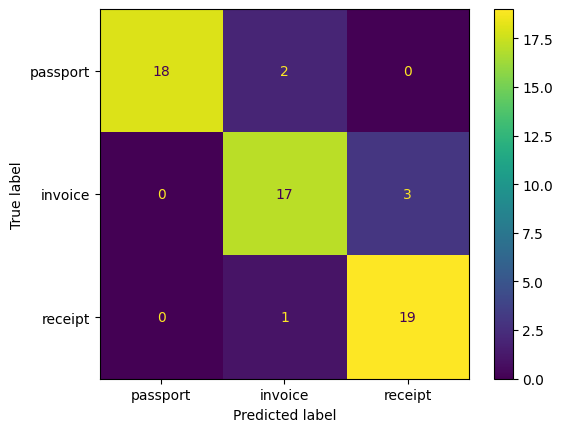

              precision    recall  f1-score   support

     invoice       0.85      0.85      0.85        20
    passport       1.00      0.90      0.95        20
     receipt       0.86      0.95      0.90        20

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



In [46]:
predictions = []
actual_labels = []
for i,row in valid_df.iterrows():
  ocr_text= row['doc_text']
  actual_labels.append(row['doc_type'])
  xq = model.encode([ocr_text]).tolist()
  result = index.query(xq, top_k=1, includeMetadata=True)

  doc_types = [match['metadata']['doc_type'] for match in result['matches']]
  max_occurrence_doc_type = max(doc_types, key=doc_types.count)
  predictions.append(max_occurrence_doc_type)
  # print((row['doc_type'], max_occurrence_doc_type))

evaluate_predictions(actual_labels, predictions)